In [652]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from pandas.plotting import scatter_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import pickle

### First, i'm going to prepare the data before training

In [663]:
diamonds_train = pd.read_csv('../input/data.csv')
diamonds_test = pd.read_csv('../input/test.csv')

In [664]:
diamonds_train.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,2.26,Ideal,G,SI2,61.9,57.0,8.44,8.36,5.20,12831
1,2.43,Very Good,H,SI2,63.2,57.0,8.56,8.50,5.39,16170
2,0.80,Premium,F,SI2,61.0,57.0,6.03,6.01,3.67,2797
3,0.40,Ideal,F,I1,63.3,60.0,4.68,4.64,2.95,630
4,0.31,Ideal,G,VS2,61.6,55.0,4.39,4.37,2.70,698


In [655]:
# Correlation with Seaborn to see the correlation between variables

def Graphs(data):
    sns.set(style="ticks", color_codes=True)
    graph = sns.pairplot(data)
    return graph, data.describe()

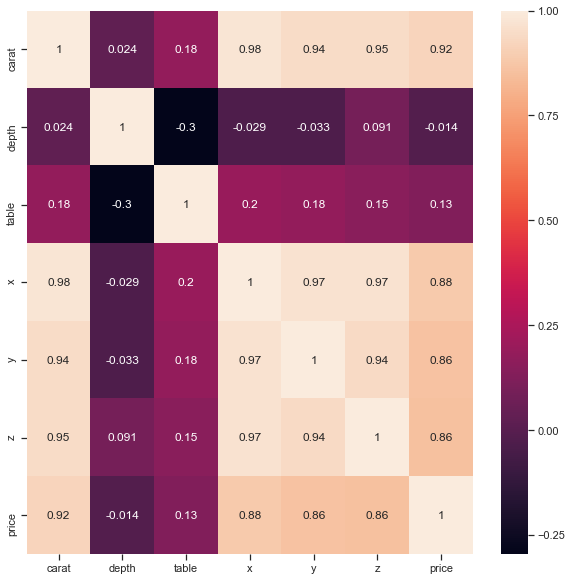

In [575]:
plt.figure(figsize=(10,10))
sns.heatmap(diamonds_train.corr(), annot=True)

#As we can see column 'x' has a high correlation with 'carat'

### - There is a high correlation between x & z and y & z. For the reason I drop that columns

In [665]:
diamonds_train = diamonds_train.drop(columns=['x', 'y'])
diamonds_test = diamonds_test.drop(columns=['id', 'x', 'y'])

### - One of the options to categorical columns is to use get dummies. At the beginnig, i did it but the results were not better than other 

In [521]:
def get_dummies(data, list_columns):
    data_copy = data.copy()
    return pd.get_dummies(data_copy, columns=list_columns, drop_first=True)

diamonds_train_copy = get_dummies(diamonds_train, ['cut', 'color', 'clarity'])
diamonds_test_copy = get_dummies(diamonds_test, ['cut', 'color', 'clarity'])

### - I decided to create my on dicctionary with the values, depends on which label is more important

In [666]:
def categorialDicc(data):
    
    data['cut']=data['cut'].map({'Ideal':1,'Good':2,'Very Good':3,'Fair':4,'Premium':5})
    data['color']=data['color'].map({'E':1,'D':2,'F':3,'G':4,'H':5,'I':6,'J':7})
    data['clarity']=data['clarity'].map({'VVS1':1,'IF':2,'VVS2':3,'VS1':4,'I1':5,'VS2':6,'SI1':7,'SI2':8})
    return data

diamonds_train_copy = categorialDicc(diamonds_train)
diamonds_test_copy = categorialDicc(diamonds_test)

### - It's important to create new features to obtain good results in our model. I found a relationship between table & cut and depth & cut. I calculate the mean of them

In [667]:
diamonds_train_copy['mean_cut_table'] = diamonds_train_copy['table']/diamonds_train['cut']
diamonds_train_copy['mean_cut_depth'] = diamonds_train_copy['depth']/diamonds_train['cut']
diamonds_test_copy['mean_cut_table'] = diamonds_test_copy['table']/diamonds_test['cut']
diamonds_test_copy['mean_cut_depth'] = diamonds_test_copy['depth']/diamonds_test['cut']

### - I standardize the numerical values

In [668]:
diamonds_train_copy[['carat','depth','table', 'z', 'mean_cut_table', 'mean_cut_depth']] = scaler.fit_transform(diamonds_train_copy[['carat','depth','table', 'z','mean_cut_table', 'mean_cut_depth']])
diamonds_test_copy[['carat','depth','table', 'z', 'mean_cut_table', 'mean_cut_depth']] = scaler.transform(diamonds_test_copy[['carat','depth','table', 'z','mean_cut_table', 'mean_cut_depth']])

In [669]:
diamonds_test_copy.head()

,carat,cut,color,clarity,depth,table,z,mean_cut_table,mean_cut_depth
0,-0.502553,1,6,6,0.245805,-1.550377,-0.337518,1.089424,1.211268
1,0.530446,1,4,6,0.106170,-0.653969,0.719265,1.192022,1.202098
2,-0.629043,5,1,6,-0.173100,-0.653969,-0.577056,-1.106167,-1.071898
3,0.003405,1,3,4,0.734528,-0.653969,0.268371,1.192022,1.243360
4,-0.544716,1,4,4,-0.242918,-0.205764,-0.478423,1.243321,1.179175


In [670]:
diamonds_train_copy.head()

,carat,cut,color,clarity,depth,table,z,price,mean_cut_table,mean_cut_depth
0,3.081321,1,4,8,0.106170,-0.205764,2.339667,12831,1.243321,1.202098
1,3.439708,3,5,8,1.013798,-0.205764,2.607386,16170,-0.706036,-0.669975
2,0.003405,5,3,8,-0.522188,-0.205764,0.183828,2797,-1.095907,-1.076483
3,-0.839859,1,3,5,1.083616,1.138849,-0.830684,630,1.397217,1.266284
4,-1.029593,1,4,6,-0.103283,-1.102173,-1.182945,698,1.140723,1.188344


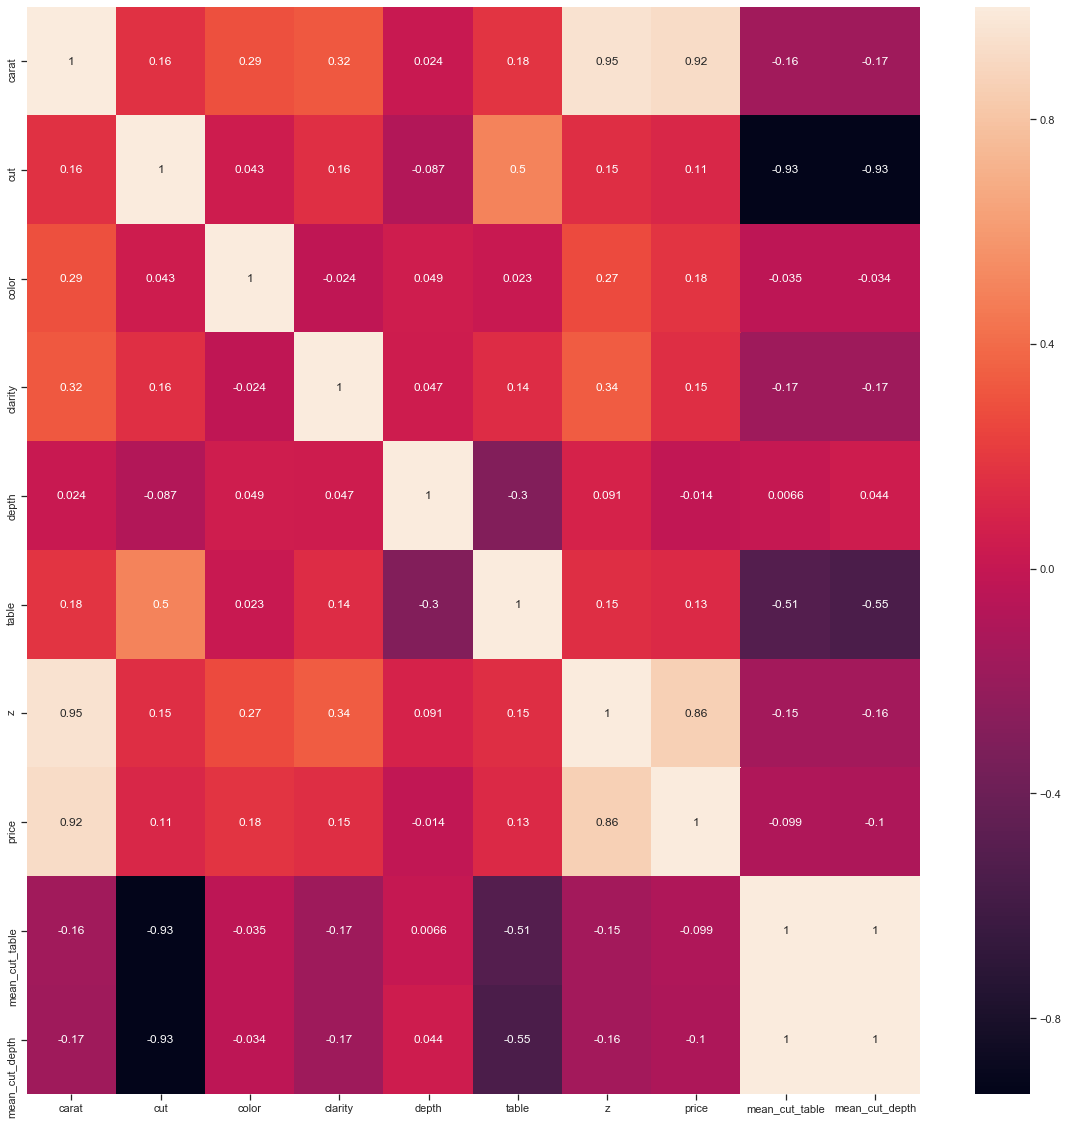

In [671]:
plt.figure(figsize=(20,20))
sns.heatmap(diamonds_train_copy.corr(), annot=True)
plt.show()

### - The first time i perform a PCA to reduce dimensionality but the results were better when I avoid it. I keep the function to test it in the future with other parameters

In [486]:
# Reduction dimensionality with PCA
def dimensionality(data, test):
    pca = PCA(n_components=6)
    data_pca = pd.DataFrame(pca.fit_transform(data))
    data_test = pd.DataFrame(pca.transform(test))
    return data_pca, data_test
diamonds_train_copy, diamonds_test_copy = dimensionality(diamonds_train_copy, diamonds_test_copy)

### - I split the dataframe to train our model

In [ ]:
x = diamonds_train_copy.drop(columns=['price'])

In [673]:
# Split into train and test our dataset

def splitData(data, y, test_size):
    x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=test_size)
    return x_train, x_test, y_train, y_test

In [674]:
x_train, x_test, y_train, y_test = splitData(x, diamonds_train['price'], 0.2)

## Models

- ### Gradient Boosting Regressor

In [675]:
gb = GradientBoostingRegressor(n_estimators=2000, learning_rate = 0.1, loss='ls', max_depth = 3)
gb.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=2000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [676]:
# Calculate MSE to determine if our model predicts well

def metrics(x_test, model, y_test):
    prediction = model.predict(x_test)
    mse = mean_squared_error(y_test, prediction)**0.5
    r2 = r2_score(y_test, prediction)
    return "The squared mean error is {} and the r2 score is {}".format(mse, r2)

In [677]:
metrics(x_test, gb, y_test)

'The squared mean error is 564.4451139017108 and the r2 score is 0.9807128252185441'

In [680]:
prediction_gradient = gb.predict(diamonds_test_copy)

In [681]:
# Our predictions to DataFrame

def DataframePredict(predictions, model):
    data_predictions = pd.DataFrame(predictions)
    data_predictions.reset_index(level=0, inplace=True)
    data_predictions = data_predictions.rename(columns={"index": "id", 0: "price"})
    data_predictions.reset_index(drop=True)
    data_predictions.price = data_predictions.price.apply(lambda x: round(x, 2))
    data_predictions.to_csv('../output/prediction_{}.csv'.format(model), index=False)

In [682]:
DataframePredict(prediction_gradient, "gradient_boosting")

- ### Random Forest Regressor

In [683]:
regr = RandomForestRegressor(n_estimators=1000, warm_start=False, min_samples_leaf=2, min_samples_split=4)

In [684]:
regr.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [685]:
metrics(x_test, regr, y_test)

'The squared mean error is 553.6628005772611 and the r2 score is 0.981442653770732'

In [688]:
prediction = regr.predict(diamonds_test_copy)

In [689]:
DataframePredict(prediction, "randomForest")

In [651]:
# We save our best model model
pickle_name = "pickle_random_forest_563.pkl"  

with open(pickle_name, 'wb') as file:  
    pickle.dump(regr, file)

### - Now, I test Random Forest Regressor using GridSearch to find the best parameters. 

In [625]:
regr_grid = RandomForestRegressor()

In [626]:
param_grid = {
'n_estimators': [600,700,1000,1200],
 'min_samples_split': [2,3,4],
 'min_samples_leaf': [1,2,3,4],
 'max_depth': [None],
'warm_start': [False]}

In [627]:
mse_scorer = make_scorer(mean_squared_error)

In [628]:
grid_search = GridSearchCV(estimator = regr_grid, param_grid = param_grid, cv = 2, verbose = 2, scoring=mse_scorer)

In [687]:
#grid_search.fit(x_train, y_train)

In [ ]:
grid_search.best_estimator_.fit(x_train, y_train)

In [ ]:
grid_search.best_estimator_.score(x_train, y_train)

In [ ]:
metrics(x_test, grid_search.best_estimator_, y_test)

In [289]:
prediction_grid_search = grid_search.best_estimator_.predict(diamonds_test_copy)

In [290]:
DataframePredict(prediction_grid_search, "grid_search")